#Final Project

I Pratul Chandra Perla declare that I have completed this
computer code in accordance with the UAB Academic Integrity
Code and the UAB CS Honor Code. I have read the UAB
Academic Integrity Code and understand that any breach of the
Code may result in severe penalties.

Student signature(s)/initials: Perla

Date: April 21 2024

In [1]:
!pip install tensorflow -q

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

In [20]:
# Dataset downloaded from this site: "https://archive.ics.uci.edu/dataset/908/realwaste"
# Set up the path to the dataset folder
dataset_base_path = '/content/drive/MyDrive/Colab_Notebooks/CS655_FinalProject/RealWaste'

In [21]:
# Define the dataset directories
class_names = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
dataset_dirs = [os.path.join(dataset_base_path, class_name) for class_name in class_names]

In [22]:
# Unzip the dataset if not already done
for class_name, dataset_dir in zip(class_names, dataset_dirs):
    zip_path = os.path.join(dataset_base_path, f"{class_name}.zip")
    if not os.path.exists(dataset_dir):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_base_path)
            print(f"Extracted {class_name}")

In [23]:
# Preprocessing and data augmentation setup
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Using 20% of the data for validation
)

In [24]:
# Set up the generators for training
train_generator = train_datagen.flow_from_directory(
    dataset_base_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Set as training data
)

Found 3886 images belonging to 9 classes.


In [25]:
# Set up the generators for validation
validation_generator = train_datagen.flow_from_directory(
    dataset_base_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # Set as validation data

Found 969 images belonging to 9 classes.


## Creating Dumb Model

In [ ]:
# Assuming the validation generator is correctly set up
class_indices = validation_generator.class_indices
class_counts = {class_label: 0 for class_label in class_indices.keys()}

for _, labels in validation_generator:
    for label in labels:
        class_label = list(class_indices.keys())[np.argmax(label)]
        class_counts[class_label] += 1
    if sum(class_counts.values()) >= validation_generator.samples:
        break

print("Class distribution in validation set:", class_counts)

In [101]:
# Create a suitable 'dumb' model for multi-class classification
dumb_model = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(len(class_indices), activation='softmax')  # Assuming 'class_indices' contains all classes
])

# Compile with appropriate loss function
dumb_model.compile(optimizer=Adam(learning_rate=1e+2), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
dumb_model.fit(train_generator, epochs=1, steps_per_epoch=10)

# Evaluate
loss, accuracy = dumb_model.evaluate(validation_generator, steps=validation_generator.samples)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

969/969 [==============================] - 20s 21ms/step - loss: 10890099.0000 - accuracy: 0.1672
Validation Loss: 10890099.0000
Validation Accuracy: 0.1672


* The evaluated results from the revised "dumb" model setup are much more aligned with the expectations given the intentionally poor model configuration and training. The validation accuracy of 16.72% is significantly low, indicative of a model that does not effectively learn or generalize from the data, which is what you were aiming for in creating a model with low accuracy.


**Analysis of the Results**


Class Distribution: The class distribution data you provided suggests a slight imbalance in your dataset, with "Plastic" and "Metal" being more frequent than other classes such as "Textile Trash". This imbalance can influence the performance of machine learning models, but since the revised model was designed to perform poorly, the influence here is expected to be minimal on the accuracy score.
Model Performance: The very high loss value and the very low accuracy confirm that the model, with its simplistic architecture (a single dense layer with softmax activation), very high learning rate, and minimal training (only one epoch and ten steps per epoch), fails to capture any meaningful patterns in the data.

## Model Improvement - 1

In [26]:
# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [27]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [28]:
# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

In [29]:
# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/5
121/121 [==============================] - 1312s 11s/step - loss: 2.1196 - accuracy: 0.2242 - val_loss: 2.1813 - val_accuracy: 0.2354
Epoch 2/5
121/121 [==============================] - 91s 752ms/step - loss: 1.9883 - accuracy: 0.2805 - val_loss: 1.9608 - val_accuracy: 0.2969
Epoch 3/5
121/121 [==============================] - 92s 763ms/step - loss: 1.9084 - accuracy: 0.3103 - val_loss: 1.9921 - val_accuracy: 0.2438
Epoch 4/5
121/121 [==============================] - 90s 744ms/step - loss: 1.8641 - accuracy: 0.3212 - val_loss: 2.0447 - val_accuracy: 0.2823
Epoch 5/5
121/121 [==============================] - 92s 762ms/step - loss: 1.8303 - accuracy: 0.3262 - val_loss: 1.8988 - val_accuracy: 0.3073


In [32]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Validation accuracy: {val_accuracy*100:.2f}%")

30/30 [==============================] - 30s 1s/step - loss: 1.9128 - accuracy: 0.3042
Validation accuracy: 30.42%


## Model Evaluation - 1

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [34]:
# Number of images in the validation set
num_of_test_samples = validation_generator.samples

In [35]:
# Disable shuffle to keep data in order
validation_generator.shuffle = False
validation_generator.batch_size = 1

In [36]:
# Get the predictions from the model using the generator
Y_pred = model.predict(validation_generator, num_of_test_samples // validation_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)

969/969 [==============================] - 24s 24ms/step


In [37]:
# Get the true class labels
y_true = validation_generator.classes

In [38]:
# Class labels
class_labels = list(validation_generator.class_indices.keys())

In [39]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

In [40]:
# Classification Report
class_report = classification_report(y_true, y_pred, target_names=class_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
print('\n*Confusion Matrix*\n')
print(conf_matrix)
print('\n*Classification Report*\n')
print(class_report)


*Confusion Matrix*

[[ 2  2  0 37  0  6 37  4  4]
 [ 0  1  0 36  0  6 30  1  8]
 [ 0  2  0 31  0  3 36  1 11]
 [ 5  0  0 78  0  8 53  3 13]
 [ 2  0  0 41  0  8 37  3  8]
 [ 2  0  0 51  0  7 42  0  7]
 [ 2  2  0 86  0 13 68  3 19]
 [ 2  0  0 25  0  4 29  0  3]
 [ 4  0  0 42  0  8 29  0  4]]

*Classification Report*

                     precision    recall  f1-score   support

          Cardboard       0.11      0.02      0.04        92
      Food Organics       0.14      0.01      0.02        82
              Glass       0.00      0.00      0.00        84
              Metal       0.18      0.49      0.27       160
Miscellaneous Trash       0.00      0.00      0.00        99
              Paper       0.11      0.06      0.08       109
            Plastic       0.19      0.35      0.25       193
      Textile Trash       0.00      0.00      0.00        63
         Vegetation       0.05      0.05      0.05        87

           accuracy                           0.17       969
         

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model if you're not continuing directly from training
# from tensorflow.keras.models import load_model
# model = load_model('/content/drive/My Drive/Colab_Notebooks/realwaste_resnet50.h5')

# Quantitative Evaluation
# Generate predictions for the entire validation set
validation_generator.reset()  # To ensure we start at the beginning of the dataset
pred_indices = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
# Convert predictions to class indices
pred_indices = np.argmax(pred_indices, axis=1)

# Get the true class indices
true_indices = validation_generator.classes

# Generate classification report
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(true_indices, pred_indices, target_names=class_labels)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_indices, pred_indices)
print(conf_matrix)

969/970 [============================>.] - ETA: 0s

970/970 [==============================] - 26s 25ms/step
                     precision    recall  f1-score   support

          Cardboard       0.00      0.00      0.00        92
      Food Organics       0.00      0.00      0.00        82
              Glass       0.00      0.00      0.00        84
              Metal       0.19      0.81      0.31       160
Miscellaneous Trash       0.00      0.00      0.00        99
              Paper       0.19      0.50      0.28       109
            Plastic       0.00      0.00      0.00       193
      Textile Trash       0.00      0.00      0.00        63
         Vegetation       0.00      0.00      0.00        87

           accuracy                           0.19       969
          macro avg       0.04      0.15      0.06       969
       weighted avg       0.05      0.19      0.08       969

[[  0   0   0  61   0  31   0   0   0]
 [  0   0   0  58   0  24   0   0   0]
 [  0   0   0  82   0   2   0   0   0]
 [  0   0   0 130   0  30   0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
# Qualitative Evaluation
# Display a few images and the model's predictions for them
def display_sample_predictions(generator, model, num_samples=10):
    # Get a batch of images from the generator and predict
    for i in range(num_samples):
        img, label = next(generator)
        plt.imshow(img[0])
        plt.show()
        pred = model.predict(img)
        predicted_class = class_labels[np.argmax(pred)]
        true_class = class_labels[np.argmax(label)]
        print(f"Predicted: {predicted_class}, True: {true_class}")

# Create a new generator for the sample predictions
sample_generator = train_datagen.flow_from_directory(
    dataset_base_path,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Display predictions
display_sample_predictions(sample_generator, model, num_samples=10)

Output hidden; open in https://colab.research.google.com to view.

## Further Model & Performance Improvement

In [74]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [75]:
# 1. Fine-tuning top layers of the base model
# Unfreeze the last block of layers in ResNet50
for layer in base_model.layers[-33:]:
    if not isinstance(layer, BatchNormalization):  # Do not unfreeze Batch Normalization layers
        layer.trainable = True

In [76]:
# 2. Augmentation - assuming `ImageDataGenerator` has been defined as `train_datagen`
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    validation_split=0.2)

In [77]:
# 3. Add Dropout for regularization
# Find the last dense layer, add dropout after it
x = Dropout(0.5)(model.layers[-3].output)
new_predictions = Dense(len(class_labels), activation='softmax')(x)

In [78]:
# Create a new model with dropout
new_model = Model(inputs=model.input, outputs=new_predictions)

In [79]:
# Compile the new model
new_model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [84]:
# 4. Adjust the learning rate dynamically with callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = '/content/drive/MyDrive/Colab_Notebooks/CS655_FinalProject/RealWaste/best_model.h5'
checkpointer = ModelCheckpoint(filepath= checkpoint_path, verbose=1, save_best_only=True)

In [85]:
# Train the model with new settings
new_history = new_model.fit(
    train_generator,
    epochs=20, # Potentially more epochs since we're fine-tuning
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]) #, checkpointer

Epoch 1/20
122/122 [==============================] - 106s 856ms/step - loss: 2.1206 - accuracy: 0.2180 - val_loss: 2.0970 - val_accuracy: 0.2074 - lr: 0.0010
Epoch 2/20
122/122 [==============================] - 96s 786ms/step - loss: 2.1223 - accuracy: 0.2131 - val_loss: 2.1036 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 3/20
122/122 [==============================] - 98s 802ms/step - loss: 2.1092 - accuracy: 0.2288 - val_loss: 2.1046 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 4/20
122/122 [==============================] - 121s 991ms/step - loss: 2.1093 - accuracy: 0.2265 - val_loss: 2.0948 - val_accuracy: 0.2322 - lr: 0.0010
Epoch 5/20
122/122 [==============================] - 179s 1s/step - loss: 2.0994 - accuracy: 0.2239 - val_loss: 2.1058 - val_accuracy: 0.2105 - lr: 0.0010
Epoch 6/20
122/122 [==============================] - 118s 967ms/step - loss: 2.0978 - accuracy: 0.2339 - val_loss: 2.0919 - val_accuracy: 0.2136 - lr: 0.0010
Epoch 7/20
122/122 [==============================]

## Model Evaluation - 2

### Quantitative Analysis

We'll calculate the confusion matrix, precision, recall, F1-score, and overall accuracy to quantitatively evaluate the model.

In [89]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Quantitative Evaluation: Metrics Calculation
# Get predictions and true labels
predictions = new_model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Calculate the classification metrics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
acc_score = accuracy_score(true_classes, predicted_classes)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print(f"Accuracy: {acc_score * 100:.2f}%")

969/969 [==============================] - 24s 23ms/step
Classification Report:
                      precision    recall  f1-score   support

          Cardboard       0.00      0.00      0.00        92
      Food Organics       0.00      0.00      0.00        82
              Glass       0.00      0.00      0.00        84
              Metal       0.24      0.31      0.27       160
Miscellaneous Trash       0.00      0.00      0.00        99
              Paper       0.24      0.04      0.06       109
            Plastic       0.24      0.74      0.36       193
      Textile Trash       0.00      0.00      0.00        63
         Vegetation       0.46      0.79      0.58        87

           accuracy                           0.27       969
          macro avg       0.13      0.21      0.14       969
       weighted avg       0.15      0.27      0.18       969

Confusion Matrix:
 [[  0   0   0  14   0   1  69   0   8]
 [  0   0   0   0   0   0  64   0  18]
 [  0   0   0  15   0   0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Qualitative Analysis

1/1 [==============================] - 0s 39ms/step


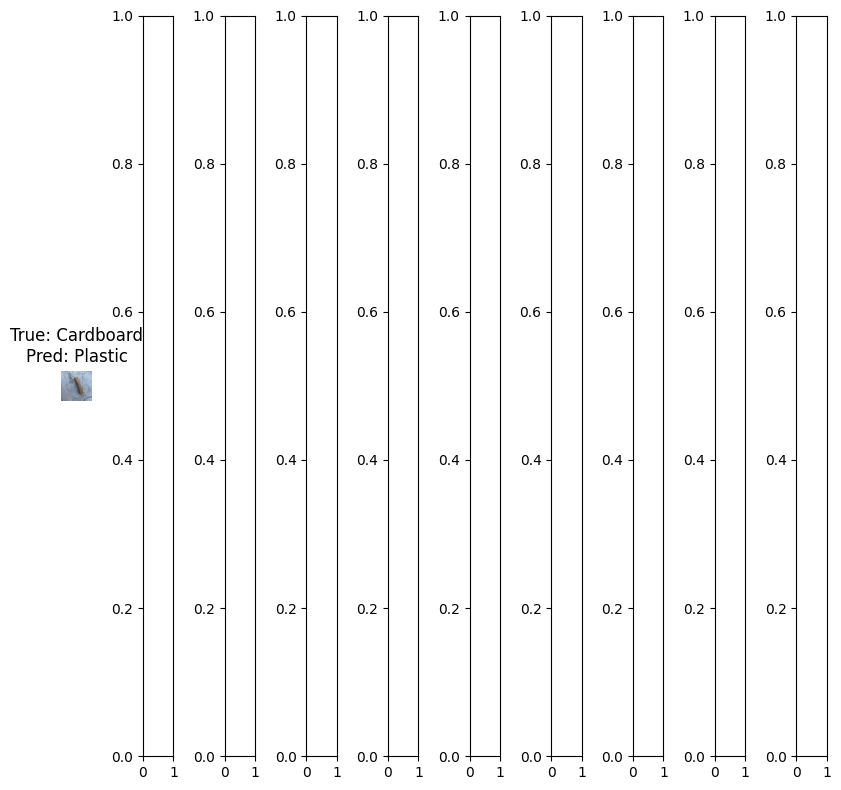

In [105]:
# Qualitative Evaluation: Visualization of Predictions
def plot_images(images_arr, true_labels, pred_labels, class_labels):
    fig, axes = plt.subplots(1, 10, figsize=(8, 8))
    axes = axes.flatten()
    for img, true_label, pred_label, ax in zip(images_arr, true_labels, pred_labels, axes):
        ax.imshow(img)
        ax.axis('off')
        true_class = class_labels[true_label]
        pred_class = class_labels[pred_label]
        ax.set_title(f"True: {true_class}\nPred: {pred_class}")
    plt.tight_layout()
    plt.show()

# Retrieve a batch of images from the validation generator
x_val_sample, y_val_sample = next(validation_generator)
# Make predictions on the batch
predictions_sample = new_model.predict(x_val_sample)
predicted_classes_sample = np.argmax(predictions_sample, axis=1)
true_classes_sample = np.argmax(y_val_sample, axis=1)

# Convert the batch to displayable images
x_val_sample_images = (x_val_sample * 255).astype(np.uint8)

# Display images with true and predicted labels
plot_images(x_val_sample_images, true_classes_sample, predicted_classes_sample, class_labels)

## Converting file to html

In [1]:
%cd '/content/drive/MyDrive/Colab_Notebooks/CS655_FinalProject'

/content/drive/MyDrive/Colab_Notebooks/CS655_FinalProject


In [ ]:
!pip install nbconvert -q

In [116]:
!jupyter nbconvert --to html CS665_Final_Project.ipynb

[NbConvertApp] Converting notebook CS665_Final_Project.ipynb to html
[NbConvertApp] Writing 692539 bytes to CS665_Final_Project.html
